In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Getting Data

In [2]:
proj_folder = 'C:/Users/oryan/Documents/weave-proj/'

In [3]:
df = pd.read_csv('C:/Users/oryan/Documents/PySPAM_Original_Python_MCMC/APySPAM_MCMC/data/all_coords.csv', index_col = 0)

In [4]:
df.columns

Index(['Prim_RA', 'Prim_DEC', 'Names', 'Sec_RA', 'Sec_DEC'], dtype='object')

### Getting CSV

In [5]:
df_red = df[['Names', 'Prim_RA', 'Prim_DEC', 'Sec_RA', 'Sec_DEC']]

In [6]:
df_prim = df_red[['Names', 'Prim_RA','Prim_DEC']]

In [7]:
df_prim_reorder = (
    df_prim
    .assign(names = df_red.Names.apply(lambda x: x+'_1'))
    .drop(columns = 'Names')
    .rename(columns = {'Prim_RA' : 'ra', 'Prim_DEC' : 'dec'})
)
df_prim_reorder[:5]

,ra,dec,names
0,204.970333,0.839844,Arp240_1
1,30.957167,14.738644,Arp290_1
2,144.433333,2.760164,Arp142_1
3,32.352333,-10.136006,Arp318_1
4,4.708583,-10.361625,Arp256_1


In [8]:
df_sec = df_red[['Names', 'Sec_RA','Sec_DEC']]
df_sec_reorder = (
    df_sec
    .assign(names = df_sec.Names.apply(lambda x: x+'_2'))
    .drop(columns = 'Names')
    .rename(columns = {'Sec_RA' : 'ra', 'Sec_DEC' : 'dec'})
)
df_sec_reorder[:5]

,ra,dec,names
0,204.990208,0.830667,Arp240_2
1,30.937292,14.709056,Arp290_2
2,144.437875,2.746886,Arp142_2
3,32.337292,-10.133158,Arp318_2
4,4.711833,-10.376950,Arp256_2


In [9]:
df_comb = pd.concat([df_prim_reorder, df_sec_reorder]).sort_values('names')

In [10]:
#df_comb.to_csv(f'{proj_folder}/data/potential-target-list.csv')

### Checking Alt-Az

In [11]:
7303.5 - 6938.5

365.0

In [12]:
days_since_j2000 = 7669.5 + (2*365)
days_since_j2000

8399.5

In [13]:
lat = 28.7134
long  = -17.9058

In [14]:
LST = np.zeros(365)
for i in range(365):
    LST[i] = 100.46 + (0.985647 * (days_since_j2000 + i)) + long + (15 * 23.000)

In [15]:
for i in range(365):
    while LST[i] > 360:
        LST[i] -= 360

In [16]:
ras = {}
for i in range(len(df_comb)):
    ras[df_comb.names.iloc[i].strip()] = df_comb.ra.iloc[i]

In [17]:
has = {}
for i in list(ras.keys()):
    has[i] = []
    for j in LST:
        HA = j - ras[i]
        while HA < 0:
            HA += 360
        has[i].append(HA)

In [18]:
alts = {}
azs = {}
df_tmp = df_comb.assign(Names = df_comb.names.apply(lambda x: x.strip()))
for i in list(has.keys()):
    dec = df_tmp.query('Names == @i').dec.iloc[0]
    HA_list = list(has[i])
    alts[i] = []
    azs[i] = []
    for j in HA_list:
        sin_alt = np.sin(np.deg2rad(dec)) * np.sin(np.deg2rad(lat)) + np.cos(np.deg2rad(dec))*np.cos(np.deg2rad(lat))*np.cos(np.deg2rad(j))
        alt = np.rad2deg(np.arcsin(sin_alt))
        alts[i].append(alt)

In [19]:
target_numbers = np.zeros(365)
for i in list(alts.keys()):
    alt_list = alts[i]
    for counter, j in enumerate(alt_list):
        if j >= 15:
            target_numbers[counter] += 1

In [20]:
month_cuts = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
dates = []
tmp = 0
for i in month_cuts:
    tmp += i
    dates.append(tmp)

In [21]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']

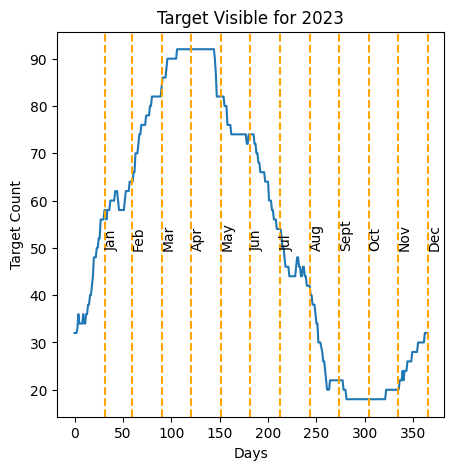

In [34]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(0,365,1), target_numbers)
for counter, i in enumerate(dates):
    plt.axvline(i, linestyle = 'dashed',color='orange')
    plt.text(i, 50, months[counter], rotation = 90)
plt.xlabel('Days')
plt.ylabel('Target Count')
plt.title('Target Visible for 2023')
plt.show()

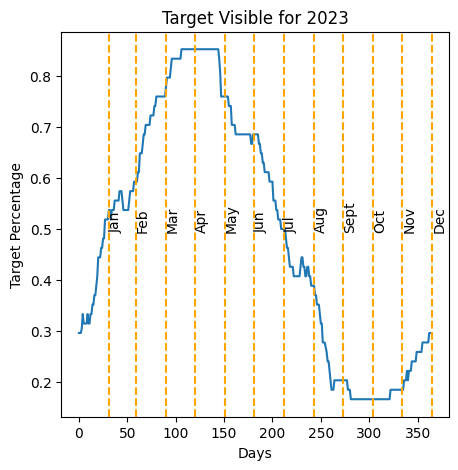

In [33]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(0,365,1), target_numbers / len(df_comb))
for counter, i in enumerate(dates):
    plt.axvline(i, linestyle = 'dashed', color='orange')
    plt.text(i, 0.5, months[counter], rotation = 90)
plt.xlabel('Days')
plt.ylabel('Target Percentage')
plt.title('Target Visible for 2023')
plt.show()